<a href="https://colab.research.google.com/github/jmolins89/final-project/blob/master/New_CNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

# Loading data ...

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
categories=['NORMAL','PNEUMONIA']
IMG_SIZE=200

def create_training_data(datadir,IMG_SIZE):
    '''
    '''
    lst=[]
    categories = ['NORMAL', 'PNEUMONIA']
    for category in categories:
        path = os.path.join(datadir, category)  # path to normal or pneumonia
        class_num=categories.index(category)    # Set category by index in categories: 0 -> Normal, 1 -> Pneumonia
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   # read the original image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizes the original image to a IMG_SIZE
                lst.append([new_array,class_num])     # Appends to the list a tuple with array resized and each label
            except Exception as e:
                pass
    return lst

training_data = create_training_data('/content/drive/My Drive/chest_xray/train',200)
test_data = create_training_data('/content/drive/My Drive/chest_xray/test',200)
validation_data = create_training_data('/content/drive/My Drive/chest_xray/val',200)

In [0]:
random.shuffle(training_data)
random.shuffle(test_data)
random.shuffle(validation_data)

In [0]:
def createxy(data):
    X,y=[],[]
    for features,label in data:
        X.append(features/255)
        y.append(label)
    return X,y
def createxyshuffled(data):
    X,y=[],[]
    for features,label in data:
        X.append(features)
        y.append(label)
    return X,y

In [0]:
X_train,y_train = createxy(training_data)
X_test,y_test = createxy(test_data)
X_val,y_val = createxy(validation_data)

In [0]:
X_train=np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test=np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val=np.array(X_val).reshape(-1,IMG_SIZE,IMG_SIZE,1)


# Exporting arrays with images and labels

In [0]:
import pickle

pickle_out = open('X_train.pickle','wb')
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open('y_train.pickle','wb')
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open('X_test.pickle','wb')
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open('y_test.pickle','wb')
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_out = open('X_val.pickle','wb')
pickle.dump(X_val, pickle_out)
pickle_out.close()

pickle_out = open('y_val.pickle','wb')
pickle.dump(y_val, pickle_out)
pickle_out.close()

In [0]:
import pickle
pickle_in1=open('/content/drive/My Drive/X_train.pickle','rb')
pickle_in2=open('/content/drive/My Drive/y_train.pickle','rb')
pickle_in3=open('/content/drive/My Drive/X_test.pickle','rb')
pickle_in4=open('/content/drive/My Drive/y_test.pickle','rb')
pickle_in5=open('/content/drive/My Drive/X_val.pickle','rb')
pickle_in6=open('/content/drive/My Drive/y_val.pickle','rb')

X_train,y_train=pickle.load(pickle_in1),pickle.load(pickle_in2)
X_test,y_test=pickle.load(pickle_in3),pickle.load(pickle_in4)
X_val,y_val=pickle.load(pickle_in5),pickle.load(pickle_in6)

In [0]:
len(X_train)

5216

In [5]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.callbacks import TensorBoard
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import ReLU
import imageio
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


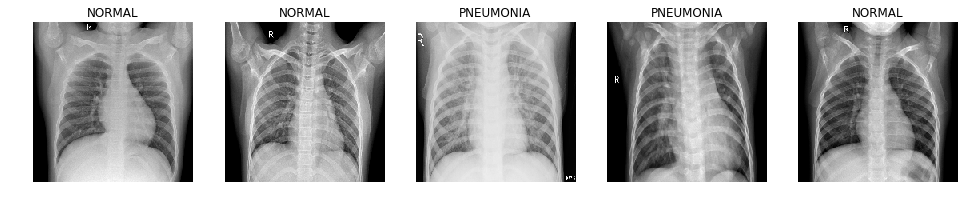

In [0]:
dic={0:'NORMAL',1:'PNEUMONIA'}
plt.figure(figsize=(20,12))
for index,img in enumerate(X_train[:5]):  
    plt.subplot(1,6,index+1)
    plt.imshow(img.reshape(200,200), cmap='gray')
    plt.axis('off')
    plt.title(dic.get(y_train[index]))
plt.show()

In the previous images **we can't distinguish the case with pneumonia against the case without pneumonia** if don't know anything about chest X-Ray reading.

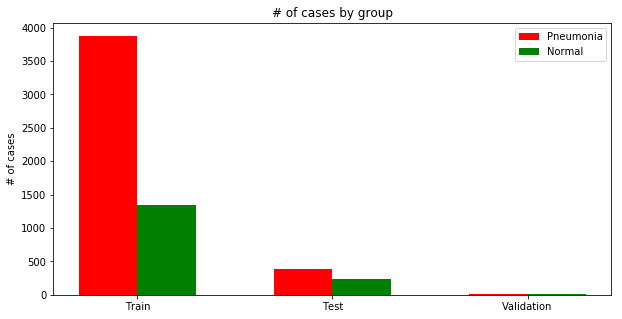

In [0]:
N = 3
normal=(y_train.count(0),y_test.count(0),y_val.count(0))
pneumonia=(y_train.count(1),y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()



In the previous graph we can observe that **the data is unbalanced**, because we have more Pneumonia cases than Normal.

We have to **rebalance** the data to train better a neural network.

We are going to **generate random images of Normal cases**.



In [20]:
np.bincount(y_train)

array([1341, 3875])

In [0]:
print('{} normal cases to create for train data'.format(np.bincount(y_train)[1]-np.bincount(y_train)[0]))

2534 normal cases to create for train data


## **Creando generador imágenes**

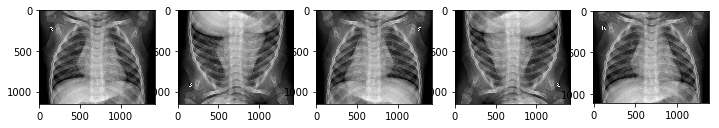

In [0]:
from google.colab.patches import cv2_imshow
imageSource = '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = cv2.imread(imageSource)
 
# copy image to display all 4 variations
horizontal_img = img.copy()
vertical_img = img.copy()
both_img = img.copy()
 
# flip img horizontally, vertically,
# and both axes with flip()
horizontal_img = cv2.flip( img, 0 )
vertical_img = cv2.flip( img, 1 )
both_img = cv2.flip( img, -1 )
 
# display the images on screen with imshow()
plt.figure(figsize=(12,4))
plt.subplot(1,5,1)
plt.imshow(img )
plt.subplot(1,5,2)
plt.imshow(horizontal_img )
plt.subplot(1,5,3)
plt.imshow(vertical_img )
plt.subplot(1,5,4)
plt.imshow( both_img )
plt.subplot(1,5,5)
plt.imshow(img[20:-20,20:-20] )
 
# wait time in milliseconds
# this is required to show the image
# 0 = wait indefinitely
cv2.waitKey(0)
 
# close the windows
cv2.destroyAllWindows()

In [0]:
normalindex=[i for i,e in enumerate(y_train) if e==0 ]
new_images=[]
new_labels=[]
for imagen in X_train[normalindex]:
  new_img = imagen[20:-20,20:-20].copy()
  new_img = cv2.resize(new_img,(200,200))
  new_images.append(new_img)
  new_labels.append(0)
  cv2.waitKey(0)

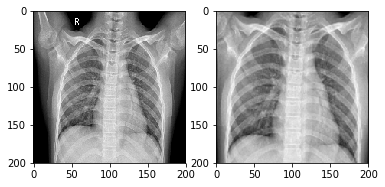

In [22]:
plt.subplot(1,2,1)
plt.imshow(X_train[normalindex][1].reshape(200,200), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(new_images[1].reshape(200,200),cmap='gray')
plt.show()

In [7]:
a=X_train
b=np.array(new_images).reshape(-1,200,200,1)
c=y_train
d=np.array(new_labels)

print(len(a))
print(len(b))
X_train_more_data = np.concatenate((a,b),axis=0)
y_train_more_data = np.concatenate((c,d),axis=0)
print(len(X_train_more_data))
print(len(y_train_more_data))
np.bincount(y_train_more_data)

5216
1341
6557
6557


array([2682, 3875])

In [8]:
to_shuffle_train=[]
for i in range(len(X_train_more_data)):
  to_shuffle_train.append([X_train_more_data[i],y_train_more_data[i]])
print('len:',len(to_shuffle_train))

len: 6557


In [0]:
random.shuffle(to_shuffle_train)

In [0]:
X_train_more_data,y_train_more_data=createxyshuffled(to_shuffle_train)
X_train_more_data=np.array(X_train_more_data).reshape(-1,200,200,1)

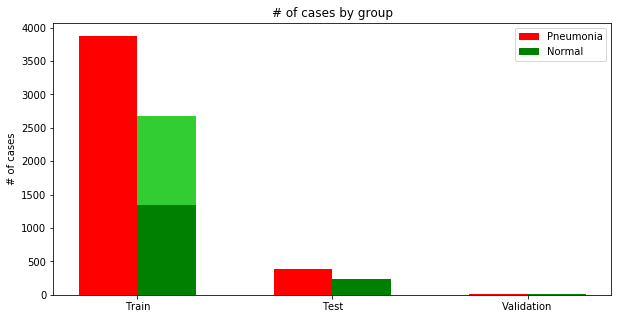

In [0]:
N = 3
normal0=(y_train.count(0),y_test.count(0),y_val.count(0))
normal=(np.bincount(y_train_more_data)[0],y_test.count(0),y_val.count(0))
pneumonia=(np.bincount(y_train_more_data)[1],y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='limegreen')
p2 = plt.bar(ind+0.15, normal0, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()

# Convolutional Neural Network

In [0]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
y_val_binary = to_categorical(y_val)
y_train_more_data_binary = to_categorical(y_train_more_data)

In [132]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 47, 47, 64)        0         
__________

In [133]:
model.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
)
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
modeltrain = model.fit(x=X_train_more_data,y=y_train_more_data_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128,shuffle=True)

Train on 5901 samples, validate on 656 samples
Epoch 1/30
5901/5901 [==============================] - 19s 3ms/step - loss: 0.7498 - acc: 0.5726 - val_loss: 0.6629 - val_acc: 0.5915
Epoch 2/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.6156 - acc: 0.6877 - val_loss: 0.6942 - val_acc: 0.4146
Epoch 3/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.6777 - acc: 0.6450 - val_loss: 0.4449 - val_acc: 0.8171
Epoch 4/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.6207 - acc: 0.6860 - val_loss: 0.5759 - val_acc: 0.8140
Epoch 5/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.4854 - acc: 0.7773 - val_loss: 0.3877 - val_acc: 0.8186
Epoch 6/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.3669 - acc: 0.8426 - val_loss: 0.2949 - val_acc: 0.8963
Epoch 7/30
5901/5901 [==============================] - 18s 3ms/step - loss: 0.3205 - acc: 0.8605 - val_loss: 0.3468 - val_acc: 0.8704
Epoch 8/

In [0]:
len(X_train_more_data)

6557

In [0]:
modeltrain.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

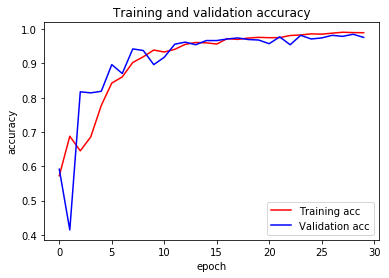

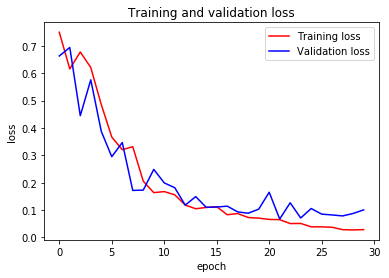

In [134]:
#Graphing our training and validation
acc = modeltrain.history['acc']
val_acc = modeltrain.history['val_acc']
loss = modeltrain.history['loss']
val_loss = modeltrain.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [135]:
val_loss,val_acc = model.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 1ms/step
1.72522411438135 0.7756410256410257


In [0]:
predictions=model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_binary.argmax(axis=1), predictions.argmax(axis=1))


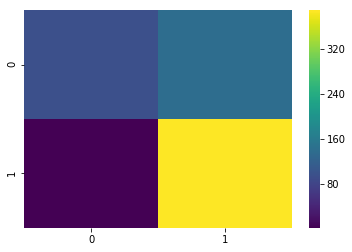

In [138]:
import seaborn as sns
sns.heatmap(matrix, cmap='viridis');

In [139]:
matrix

array([[ 96, 138],
       [  2, 388]])

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix


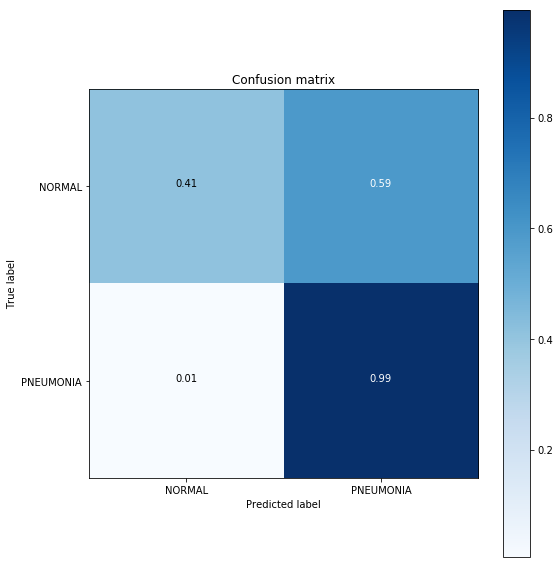

In [141]:
preds = np.argmax(model.predict(X_test), axis = 1)
cm = confusion_matrix([np.argmax(i) for i in y_test_binary],preds)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

In [142]:
from sklearn import metrics
def calculate_auc(y_true,y_predictions):
  y_true=np.array([np.argmax(y_true[i]) for i in range(len(y_true))])
  y_pred=np.array([y_predictions[i][np.argmax(y_predictions[i])] for i in range(len(y_predictions))])
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred,pos_label=1)
  auc = metrics.auc(fpr, tpr)
  return fpr,tpr,auc

fpr,tpr,auc =calculate_auc(y_test_binary,predictions)
print(auc)


0.9133957922419461


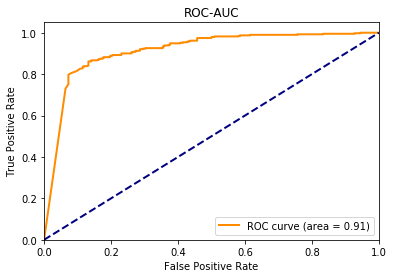

In [143]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

# Generando más imágenes para balancear la muestra

In [0]:
new_images2=[]
new_labels2=[]
for imagen in X_train[normalindex]:
  new_img = imagen[15:-15,15:-15].copy()
  new_img = cv2.resize(new_img,(200,200))
  new_images2.append(new_img)
  new_labels2.append(0)
  cv2.waitKey(0)

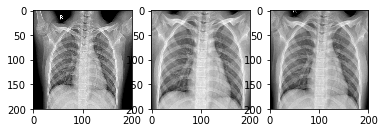

In [12]:
plt.subplot(1,3,1)
plt.imshow(X_train[normalindex][1].reshape(200,200), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(new_images[1].reshape(200,200),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(new_images2[1].reshape(200,200),cmap='gray')
plt.show()

In [13]:
a=X_train_more_data
b=np.array(new_images2).reshape(-1,200,200,1)
c=y_train_more_data
d=np.array(new_labels2)

print(len(a))
print(len(b))
X_train_more_data2 = np.concatenate((a,b),axis=0)
y_train_more_data2 = np.concatenate((c,d),axis=0)
print(len(X_train_more_data2))
print(len(y_train_more_data2))
np.bincount(y_train_more_data2)

6557
1341
7898
7898


array([4023, 3875])

In [14]:
to_shuffle_train2=[]
for i in range(len(X_train_more_data2)):
  to_shuffle_train2.append([X_train_more_data2[i],y_train_more_data2[i]])
print('len:',len(to_shuffle_train2))



len: 7898


In [0]:
random.shuffle(to_shuffle_train2)

In [0]:
X_train_more_data2,y_train_more_data2=createxyshuffled(to_shuffle_train2)
X_train_more_data2=np.array(X_train_more_data2).reshape(-1,200,200,1)

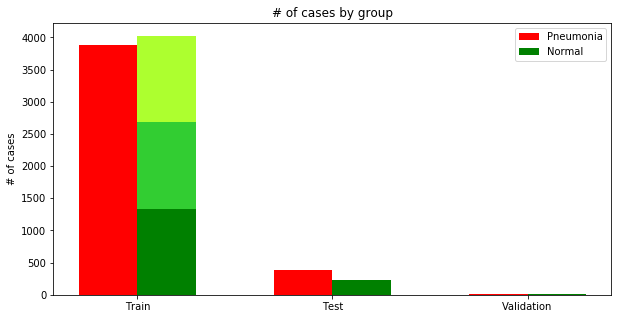

In [150]:
N = 3
normal0=(y_train.count(0),y_test.count(0),y_val.count(0))
normal=(np.bincount(y_train_more_data)[0],y_test.count(0),y_val.count(0))
normal2=(np.bincount(y_train_more_data2)[0],y_test.count(0),y_val.count(0))
pneumonia=(np.bincount(y_train_more_data)[1],y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal2, width, color='greenyellow')
p2 = plt.bar(ind+0.15, normal, width, color='limegreen')
p2 = plt.bar(ind+0.15, normal0, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()

In [0]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
y_val_binary = to_categorical(y_val)
y_train_more_data2_binary = to_categorical(y_train_more_data2)

In [152]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(32, (3,3), activation='relu'))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=2, activation='softmax'))
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 47, 47, 64)        0         
__________

In [153]:
model2.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
)

modeltrain2 = model2.fit(x=X_train_more_data2,y=y_train_more_data2_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128,shuffle=True)

Train on 7108 samples, validate on 790 samples
Epoch 1/30
7108/7108 [==============================] - 23s 3ms/step - loss: 0.6969 - acc: 0.5982 - val_loss: 0.5553 - val_acc: 0.8342
Epoch 2/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.5933 - acc: 0.6892 - val_loss: 0.3405 - val_acc: 0.8570
Epoch 3/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.3527 - acc: 0.8520 - val_loss: 0.2685 - val_acc: 0.8899
Epoch 4/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.2363 - acc: 0.9112 - val_loss: 0.1874 - val_acc: 0.9266
Epoch 5/30
7108/7108 [==============================] - 21s 3ms/step - loss: 0.2048 - acc: 0.9212 - val_loss: 0.1904 - val_acc: 0.9342
Epoch 6/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.2183 - acc: 0.9236 - val_loss: 0.1568 - val_acc: 0.9354
Epoch 7/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.1528 - acc: 0.9406 - val_loss: 0.1366 - val_acc: 0.9494
Epoch 8/

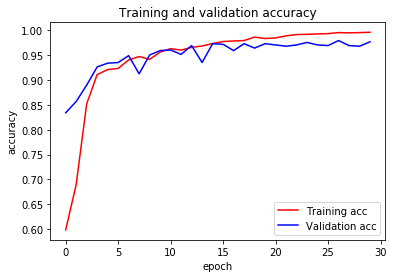

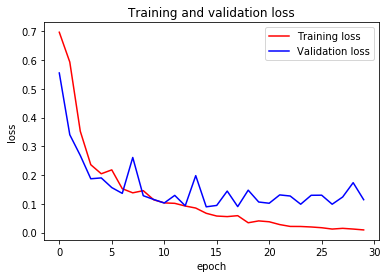

In [154]:
#Graphing our training and validation
acc = modeltrain2.history['acc']
val_acc = modeltrain2.history['val_acc']
loss = modeltrain2.history['loss']
val_loss = modeltrain2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [155]:
val_loss,val_acc = model2.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 1ms/step
1.1961669969635131 0.8333333333333334


In [0]:
predictions2=model2.predict(X_test)
matrix2 = confusion_matrix(y_test_binary.argmax(axis=1), predictions2.argmax(axis=1))


Normalized confusion matrix


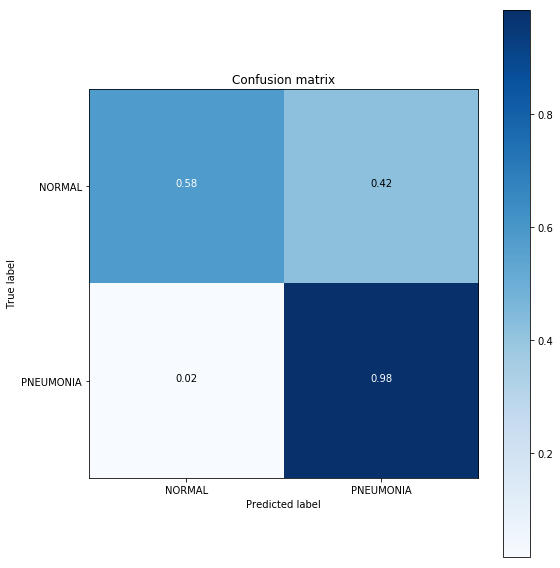

In [161]:
preds2 = np.argmax(model2.predict(X_test), axis = 1)
cm2 = confusion_matrix([np.argmax(i) for i in y_test_binary],preds2)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm2, keys, normalize=True)

In [158]:
fpr2,tpr2,auc2 =calculate_auc(y_test_binary,predictions2)

print(auc2)


0.8293776024545255


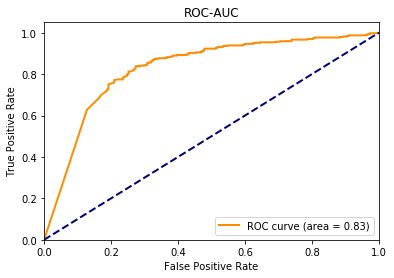

In [159]:
plt.figure()
lw = 2
plt.plot(fpr2, tpr2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show();

# Probando cambios en el último modelo

In [40]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model3.add(Conv2D(32,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(32, (3,3), activation='relu'))
model3.add(Conv2D(32,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units=2, activation='softmax'))
model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 94, 94, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 47, 47, 64)        0         
__________

In [41]:
model3.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
)

modeltrain3 = model3.fit(x=X_train_more_data2,y=y_train_more_data2_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_split=0.1, batch_size=128,shuffle=True)

Train on 7108 samples, validate on 790 samples
Epoch 1/30
7108/7108 [==============================] - 29s 4ms/step - loss: 0.6938 - acc: 0.5533 - val_loss: 0.5074 - val_acc: 0.7468
Epoch 2/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.6914 - acc: 0.5996 - val_loss: 0.5949 - val_acc: 0.7101
Epoch 3/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.4514 - acc: 0.7949 - val_loss: 0.4266 - val_acc: 0.8013
Epoch 4/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.3291 - acc: 0.8668 - val_loss: 0.2354 - val_acc: 0.9165
Epoch 5/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.2760 - acc: 0.8901 - val_loss: 0.2069 - val_acc: 0.9215
Epoch 6/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.1975 - acc: 0.9246 - val_loss: 0.1718 - val_acc: 0.9329
Epoch 7/30
7108/7108 [==============================] - 22s 3ms/step - loss: 0.1781 - acc: 0.9340 - val_loss: 0.1531 - val_acc: 0.9430
Epoch 8/

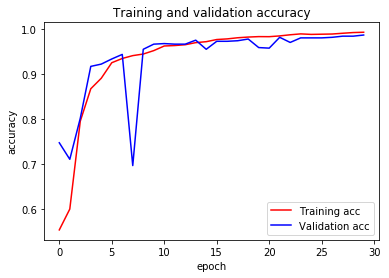

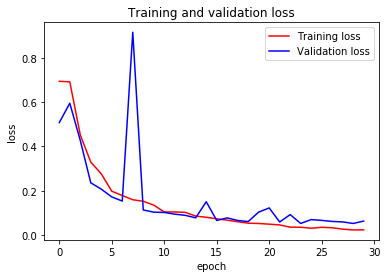

In [42]:
#Graphing our training and validation
acc = modeltrain3.history['acc']
val_acc = modeltrain3.history['val_acc']
loss = modeltrain3.history['loss']
val_loss = modeltrain3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [43]:
val_loss,val_acc = model3.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 2ms/step
1.3054475440428808 0.8205128205128205


In [0]:
predictions3=model3.predict(X_test)
matrix3 = confusion_matrix(y_test_binary.argmax(axis=1), predictions3.argmax(axis=1))


Normalized confusion matrix


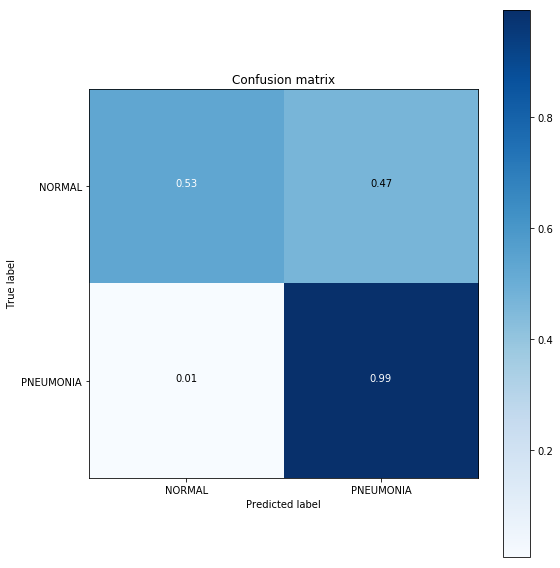

In [49]:
preds3 = np.argmax(model3.predict(X_test), axis = 1)
cm3 = confusion_matrix([np.argmax(i) for i in y_test_binary],preds3)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm3, keys, normalize=True)

In [46]:
fpr3,tpr3,auc3 =calculate_auc(y_test_binary,predictions3)

print(auc3)


0.8857988165680473


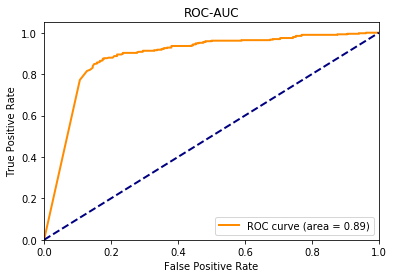

In [47]:
plt.figure()
lw = 2
plt.plot(fpr3, tpr3, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show();